<center>
    <h1><b>Phân Tích và Dự Đoán Trạng Thái Tâm Lý Qua Miêu Tả Dạng Văn Bản</b></h1>
    <h2><b>Học phần: Học máy</b></h2>
    <h3><b>Giảng viên: TS. Cao Văn Chung</b></h3>
</center>

---
**Sinh viên thực hiện:**
- Trần Anh Minh - 21000242
- Dương Đức Vương - 22000133
- Nguyễn Tuấn Kiệt - 22000100

Các thư viện cần thiết

In [44]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as mp
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re as r
from nltk.stem import PorterStemmer

 Đọc dữ liệu và cột số thứ tự không cần thiết, loại bỏ các mẫu bị thiếu dữ liệu
 

In [45]:
df=pd.read_csv("New Data.csv")

In [46]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [47]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [49]:
df['status'].value_counts()

status
Depression              26057
Normal                  16351
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [50]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [51]:
df['status'].nunique()

6

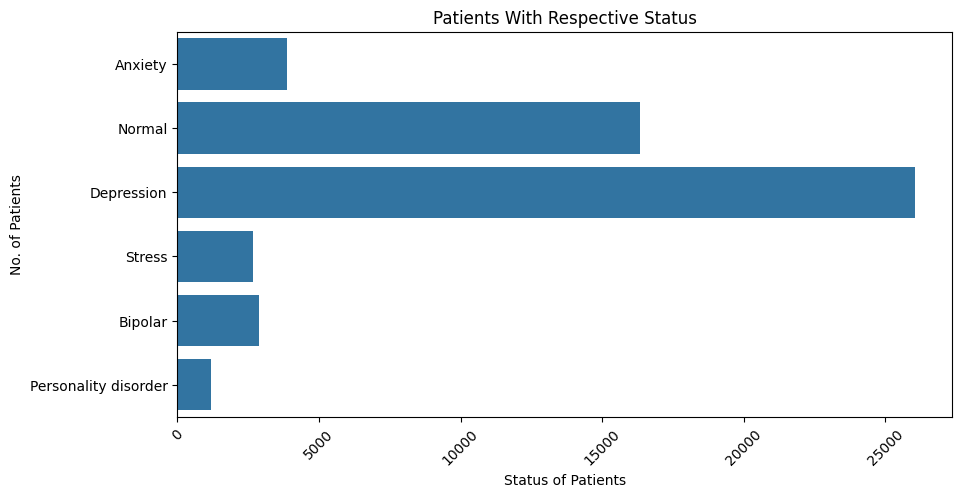

In [52]:
mp.figure(figsize=(10,5))
sn.countplot(df['status'])
mp.xlabel("Status of Patients")
mp.ylabel("No. of Patients")
mp.title("Patients With Respective Status")
mp.xticks(rotation=45)
mp.show()

In [56]:
df.dropna(inplace=True)

 Hàm resample dữ liệu để tránh mất cân bằng dữ liệu

In [59]:
def resample_data(df):
    max_count = df['status'].value_counts().max()

    df_resampled = pd.DataFrame()
    
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, 
                                          replace=True,    
                                          n_samples=max_count,    
                                          random_state=42)   
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    
    return df_resampled


df = resample_data(df)

Hàm các bước tiền xử lý dữ liệu

In [66]:
pt=PorterStemmer()
def preprocessing(x):
    l=[]

    text = r.sub(r'[^a-zA-Z0-9\s]', '', x.lower())
    for i in text.split():
        l.append(pt.stem(i.lower()))


    return " ".join(l)  

 Phân chia dữ liệu cho huấn luyện và kiểm thử với các tỷ lệ khác nhau

In [67]:
df['statement']=df['statement'].apply(preprocessing)

In [68]:
x=df['statement']
y=df['status']

In [69]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [70]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(125068,) (125068,) (31268,) (31268,)


In [71]:
vec=TfidfVectorizer()
x_train_tfidf=vec.fit_transform(x_train)
x_test_tfidf=vec.transform(x_test)

In [72]:
print(x_train_tfidf.shape,x_test_tfidf.shape)

(125068, 54552) (31268, 54552)


## KMEANS
Các thư viện cần thiết

In [74]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

Áp dụng TruncatedSVD để giảm chiều dữ liệu

In [75]:
svd = TruncatedSVD(n_components=100, random_state=42)
x_reduced = svd.fit_transform(x_train_tfidf)


 KMeans với các giá trị k từ 2 đến 10

In [76]:
k_range = range(2, 11)
inertias = []
sil_scores = []
dbi_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_reduced)
    
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(x_reduced, labels))
    dbi_scores.append(davies_bouldin_score(x_reduced, labels))

Xác định số cụm tối ưu bằng phương pháp Elbow

In [87]:
knee = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
optimal_k = knee.knee
print(f"\n Số cụm được chọn theo Elbow (k): {optimal_k}")


 Số cụm được chọn theo Elbow (k): 8


Vẽ đồ thị Elbow

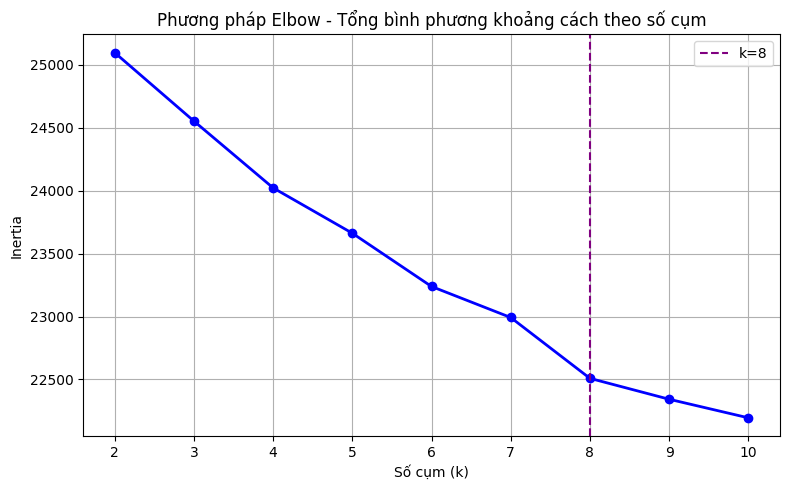

In [78]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertias, 'bo-', linewidth=2)
plt.axvline(x=optimal_k, color='purple', linestyle='--', label=f'k={optimal_k}')
plt.title("Phương pháp Elbow - Tổng bình phương khoảng cách theo số cụm")
plt.xlabel("Số cụm (k)")
plt.ylabel("Inertia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vẽ đồ thị Silhouette

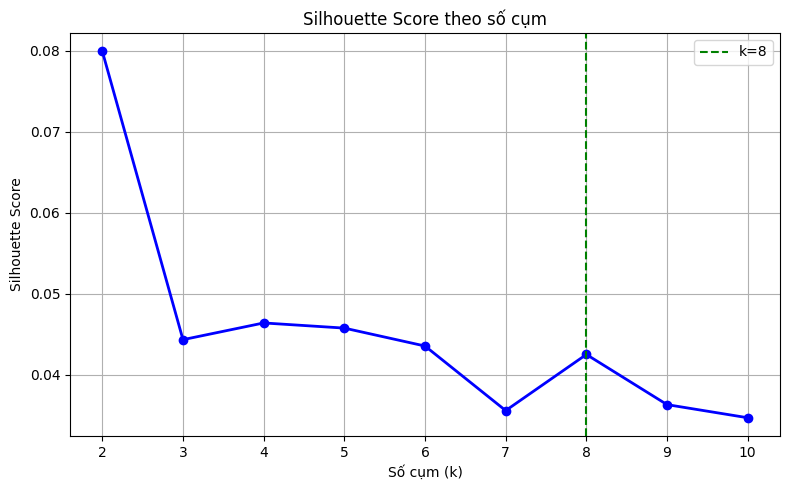

In [79]:
plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, 'b-o', linewidth=2)
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'k={optimal_k}')
plt.title("Silhouette Score theo số cụm")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vẽ đồ thị Davies-Bouldin Index

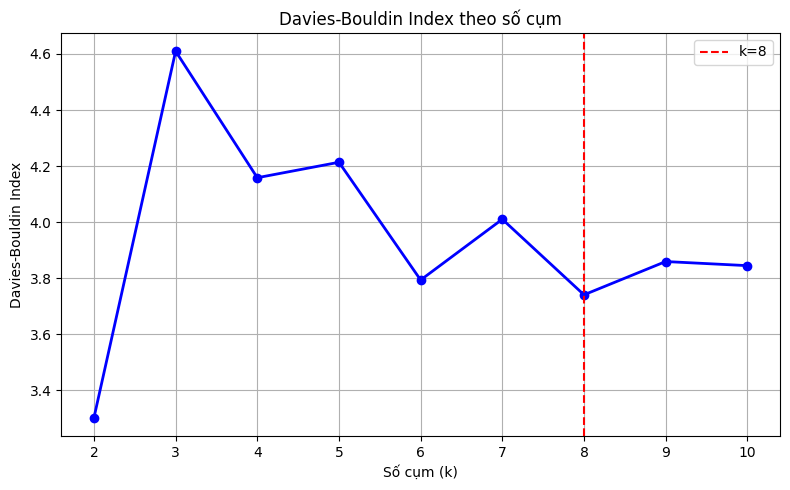

In [80]:
plt.figure(figsize=(8,5))
plt.plot(k_range, dbi_scores, 'b-o', linewidth=2)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'k={optimal_k}')
plt.title("Davies-Bouldin Index theo số cụm")
plt.xlabel("Số cụm (k)")
plt.ylabel("Davies-Bouldin Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Phân cụm KMeans với số cụm tối ưu (k = 8) và đánh giá mô hình Kmeans

In [81]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(x_reduced)

print("\n=== Đánh giá mô hình KMeans ===")
print("Silhouette Score:", silhouette_score(x_reduced, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(x_reduced, kmeans_labels))


=== Đánh giá mô hình KMeans ===
Silhouette Score: 0.04250638806965419
Davies-Bouldin Index: 3.7401503304019106


Giảm chiều dữ liệu và vẽ phân cụm KMeans trong không gian 2D

In [88]:
pca = PCA(n_components=2, random_state=42)
x_2d = pca.fit_transform(x_reduced)

Vẽ biểu đồ Kmeans

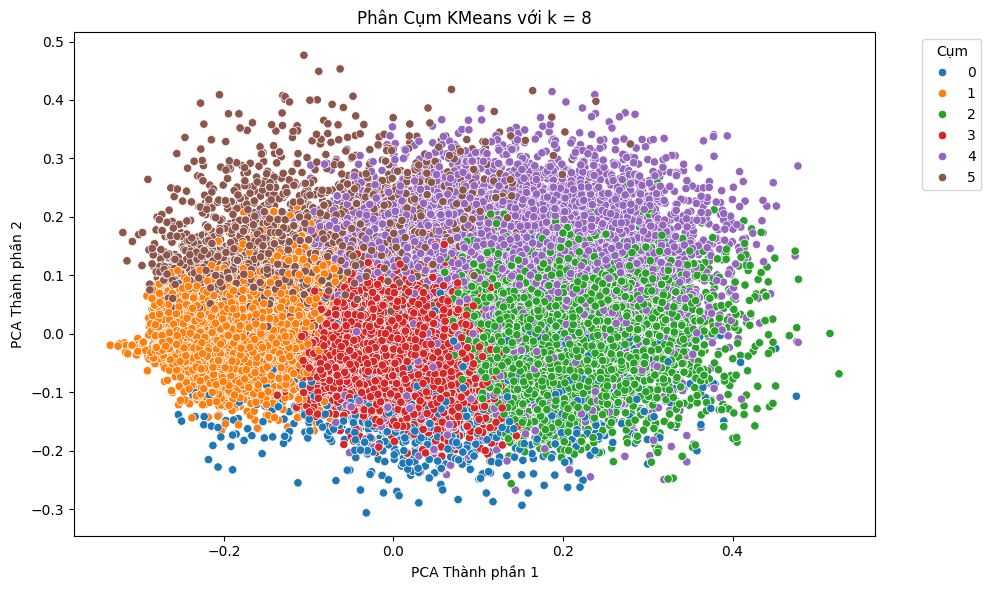

In [89]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=x_2d[:, 0], y=x_2d[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title(f"Phân Cụm KMeans với k = {optimal_k}")
plt.xlabel("PCA Thành phần 1")
plt.ylabel("PCA Thành phần 2")
plt.legend(title='Cụm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KMeans với k = 6 

In [ ]:
k = 6 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(x_reduced)

Đánh giá ARI


In [91]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_train, kmeans_labels)
nmi = normalized_mutual_info_score(y_train, kmeans_labels)

print("\n=== Đánh giá mô hình KMeans với ARI ===")
print(f"Adjusted Rand Index (ARI): {ari}")


=== Đánh giá mô hình KMeans với ARI ===
Adjusted Rand Index (ARI): 0.14676741840195884


Vẽ kết quả phân cụm KMeans với k = 6

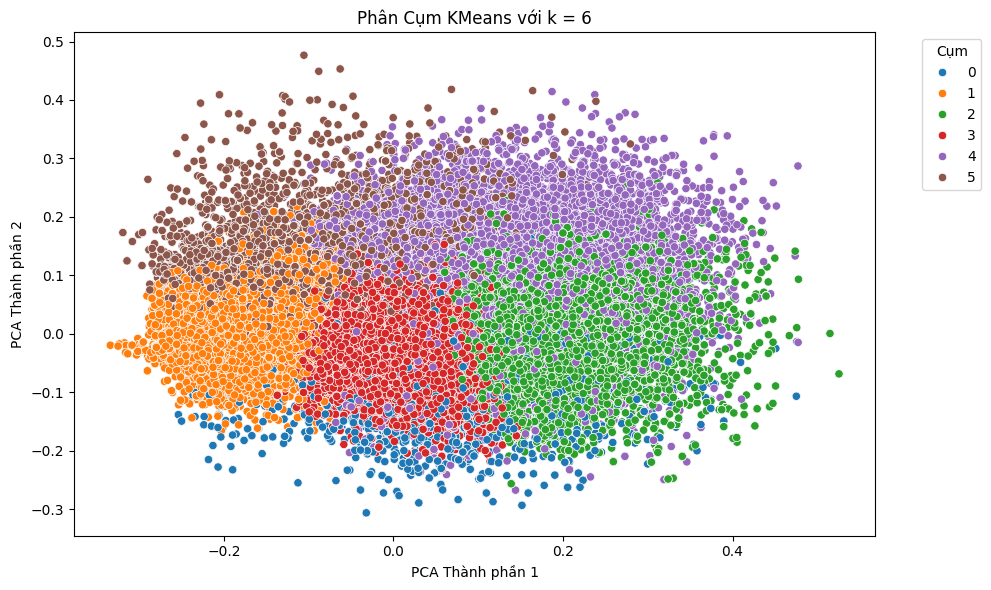

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_2d[:, 0], y=x_2d[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title(f"Phân Cụm KMeans với k = {k}")
plt.xlabel("PCA Thành phần 1")
plt.ylabel("PCA Thành phần 2")
plt.legend(title='Cụm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()